## 🤖 **Entraînement du modèle ML**

### **A. Préparation des données**

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

dataset_path = Path("../data/processed/dataset_final.csv")
if not dataset_path.exists():
	raise FileNotFoundError(f"Le fichier {dataset_path} est introuvable. Vérifiez le chemin ou générez le dataset avant de continuer.")

# Charger le dataset final
df = pd.read_csv(dataset_path)

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Période: {df['Date'].min()} à {df['Date'].max()}")
print(f"⚽ Distribution des résultats:")
print(df['Target'].value_counts(normalize=True))

df.head()

📊 Dataset shape: (1386, 24)
📅 Période: 2019-07-26 à 2024-08-10
⚽ Distribution des résultats:
Target
H    0.435065
A    0.326118
D    0.238817
Name: proportion, dtype: float64


,Date,HomeTeam,AwayTeam,Target,home_avg_goals_scored,home_avg_goals_conceded,home_avg_shots,home_avg_shots_target,home_avg_corners,home_win_rate,...,away_avg_shots_target,away_avg_corners,away_win_rate,away_form,form_difference,goal_difference,home_shot_efficiency,away_shot_efficiency,home_advantage,Target_encoded
0,2019-07-26,Genk,Kortrijk,H,1.8,1.6,15.8,5.6,5.6,0.6,...,4.2,7.8,0.4,1.4,0.6,0.6,0.333333,0.318182,0.2,0
1,2019-07-27,Cercle Brugge,Standard,A,1.2,2.0,15.8,5.2,7.6,0.2,...,1.8,2.8,0.4,1.4,-0.6,-0.6,0.309524,0.166667,-0.2,2
2,2019-07-27,St Truiden,Mouscron,A,1.2,2.8,8.6,3.2,3.4,0.0,...,3.8,5.2,0.2,0.8,-0.2,-1.0,0.333333,0.260274,-0.2,2
3,2019-07-27,Waregem,Mechelen,A,2.2,2.2,10.2,5.0,4.4,0.2,...,5.2,4.4,0.4,1.4,-0.6,0.0,0.446429,0.361111,-0.2,2
4,2019-07-27,Waasland-Beveren,Club Brugge,A,2.0,2.2,13.8,6.6,5.0,0.4,...,6.4,5.2,0.6,1.8,-0.6,-0.8,0.445946,0.372093,-0.2,2


### **B. Division temporelle**

In [3]:
# Convertir la date et trier
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Division temporelle : 80% train, 20% test
split_date = df['Date'].quantile(0.8)
train_data = df[df['Date'] <= split_date]
test_data = df[df['Date'] > split_date]

print(f"📈 Train: {len(train_data)} matchs (jusqu'au {split_date.date()})")
print(f"📊 Test: {len(test_data)} matchs (à partir du {split_date.date()})")

# Préparation des features et target
feature_cols = [col for col in df.columns if col not in ['Date', 'HomeTeam', 'AwayTeam', 'Target', 'Target_encoded']]

X_train = train_data[feature_cols]
y_train = train_data['Target_encoded']
X_test = test_data[feature_cols]
y_test = test_data['Target_encoded']

print(f"🎯 Features utilisées: {len(feature_cols)}")
print(f"📊 Shape train: {X_train.shape}")
print(f"📊 Shape test: {X_test.shape}")

📈 Train: 1109 matchs (jusqu'au 2023-08-27)
📊 Test: 277 matchs (à partir du 2023-08-27)
🎯 Features utilisées: 19
📊 Shape train: (1109, 19)
📊 Shape test: (277, 19)


### **C. Entraînement et évaluation**

In [ ]:
# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest

🎯 Accuracy: 42.960 %

📊 Classification Report:
              precision    recall  f1-score   support

        Home       0.53      0.48      0.50       125
        Draw       0.27      0.24      0.26        74
        Away       0.42      0.53      0.47        78

    accuracy                           0.43       277
   macro avg       0.41      0.42      0.41       277
weighted avg       0.43      0.43      0.43       277



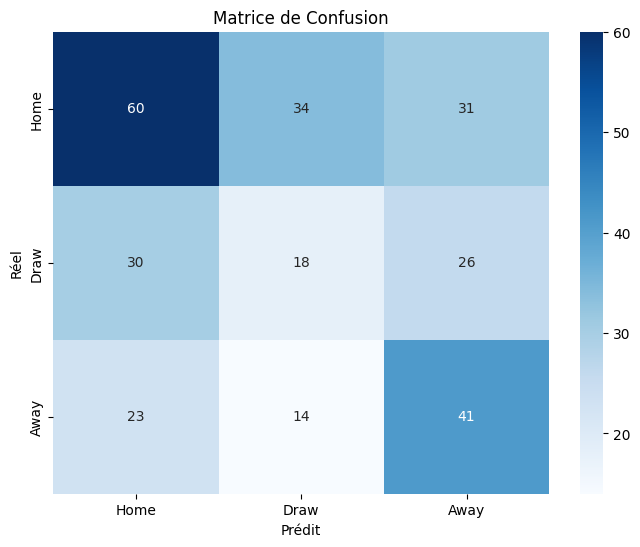

In [6]:
# Entraînement Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Important pour datasets déséquilibrés
)

rf_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Évaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = (accuracy_score(y_test, y_pred)) * 100

print(f"🎯 Accuracy: {accuracy:.3f} %")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Home', 'Draw', 'Away']))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home', 'Draw', 'Away'],
            yticklabels=['Home', 'Draw', 'Away'])
plt.title('Matrice de Confusion')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

### Gradient Boosting for classification

🎯 Accuracy: 42.960 %

📊 Classification Report:
              precision    recall  f1-score   support

        Home       0.53      0.59      0.56       125
        Draw       0.25      0.16      0.20        74
        Away       0.37      0.42      0.39        78

    accuracy                           0.43       277
   macro avg       0.38      0.39      0.38       277
weighted avg       0.41      0.43      0.42       277



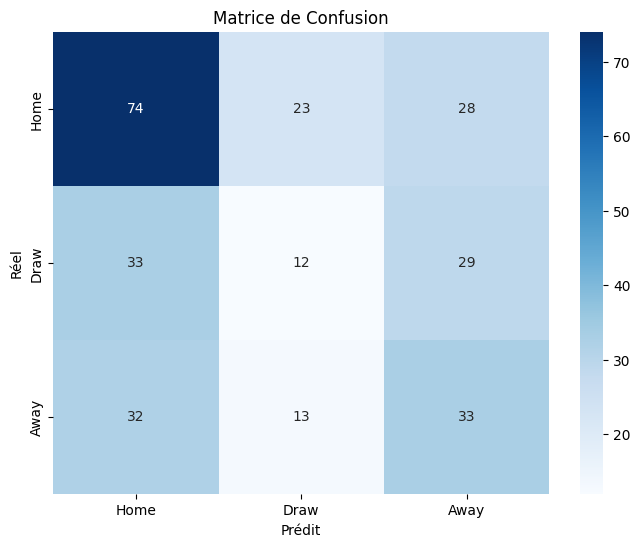

In [9]:
# Entraînement Random Forest
rf_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    learning_rate=0.1,
)

rf_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Évaluation
from sklearn.metrics import accuracy_score, classification_report
accuracy = (accuracy_score(y_test, y_pred)) * 100

print(f"🎯 Accuracy: {accuracy:.3f} %")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Home', 'Draw', 'Away']))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Home', 'Draw', 'Away'],
            yticklabels=['Home', 'Draw', 'Away'])
plt.title('Matrice de Confusion')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

## 📊 Comparaison Random Forest vs Gradient Boosting de Claudy

### 🎯 Accuracy globale : ÉGALITÉ
- **Random Forest** : 42.960%
- **Gradient Boosting** : 42.960% 
→ **Même performance globale !**

---

### 📈 Analyse détaillée par classe

#### 🏠 HOME (Victoires domicile)
| Métrique | Random Forest | Gradient Boosting | Gagnant |
|----------|---------------|-------------------|---------|
| **Precision** | 0.53 | 0.53 | 🤝 Égalité |
| **Recall** | 0.48 | 0.59 | ✅ **GB +23%** |
| **F1-score** | 0.50 | 0.56 | ✅ **GB +12%** |

#### 🤝 DRAW (Matchs nuls)
| Métrique | Random Forest | Gradient Boosting | Gagnant |
|----------|---------------|-------------------|---------|
| **Precision** | 0.27 | 0.25 | ✅ **RF +8%** |
| **Recall** | 0.24 | 0.16 | ✅ **RF +50%** |
| **F1-score** | 0.26 | 0.20 | ✅ **RF +30%** |

#### ✈️ AWAY (Victoires extérieur)
| Métrique | Random Forest | Gradient Boosting | Gagnant |
|----------|---------------|-------------------|---------|
| **Precision** | 0.42 | 0.37 | ✅ **RF +13%** |
| **Recall** | 0.53 | 0.42 | ✅ **RF +26%** |
| **F1-score** | 0.47 | 0.39 | ✅ **RF +21%** |

---

### 🏆 Verdict par spécialité

#### 🥇 Gradient Boosting excelle pour :
- Détecter les **victoires domicile** (Recall Home : 0.59 vs 0.48)
- Performance équilibrée sur les matchs à domicile

#### 🥇 Random Forest excelle pour :
- Prédire les **matchs nuls** (toutes métriques meilleures)
- Prédire les **victoires extérieur** (toutes métriques meilleures)
- **Stabilité générale** (moins de biais vers une classe)

---

### 🔍 Observation importante

#### Comportement différent :
- **Gradient Boosting** → Se **spécialise** dans les victoires domicile au détriment des autres
- **Random Forest** → Performance plus **équilibrée** entre les 3 classes

#### Macro avg (moyenne non pondérée) :
- **Random Forest** : 0.41
- **Gradient Boosting** : 0.38  
→ **RF gagne en équilibre général**

---

### 🎯 Recommandations selon l'usage

#### ✅ Choisis **Random Forest** si :
- Tu veux un modèle **équilibré** sur les 3 résultats
- Les **matchs nuls** sont importants pour ton système
- Tu privilégies la **stabilité** des prédictions

#### ✅ Choisis **Gradient Boosting** si :
- Tu te concentres sur les **victoires domicile**
- Tu veux **maximiser** la détection des "Home wins"
- Tu acceptes de sacrifier les autres classes

---


## Random Forest : Optimisation des hyperparamètres

In [10]:
## 🔧 Optimisation des hyperparamètres

from sklearn.model_selection import GridSearchCV
import time

# Paramètres à tester (version légère pour commencer)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

print("🔍 Début de l'optimisation des hyperparamètres...")
start_time = time.time()

# GridSearch avec validation croisée temporelle
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,  # 3-fold pour aller plus vite
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Afficher le progrès
)

grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"⏱️ Temps d'optimisation: {end_time - start_time:.1f} secondes")

# Afficher les résultats
print("\n🏆 Meilleurs paramètres trouvés:")
print(grid_search.best_params_)
print(f"\n🎯 Meilleure accuracy (CV): {grid_search.best_score_:.4f}")

# Tester sur le set de test
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test_scaled)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"\n📊 Accuracy sur test set:")
print(f"   Avant optimisation: 42.96%")
print(f"   Après optimisation: {accuracy_optimized*100:.3f}%")
print(f"   Amélioration: {(accuracy_optimized*100 - 42.96):.3f}%")

🔍 Début de l'optimisation des hyperparamètres...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
⏱️ Temps d'optimisation: 38.6 secondes

🏆 Meilleurs paramètres trouvés:
{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}

🎯 Meilleure accuracy (CV): 0.4770

📊 Accuracy sur test set:
   Avant optimisation: 42.96%
   Après optimisation: 48.014%
   Amélioration: 5.054%


## Gradient Boosting : Optimisation hyperparamètres

In [11]:
## 🔧 Optimisation des hyperparamètres Gradient Boosting

from sklearn.model_selection import GridSearchCV
import time

# Paramètres spécifiques à Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10]
}

print("🔍 Début de l'optimisation Gradient Boosting...")
start_time = time.time()

# GridSearch avec validation croisée
grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=3,  # 3-fold pour aller plus vite
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Afficher le progrès
)

grid_search_gb.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"⏱️ Temps d'optimisation: {end_time - start_time:.1f} secondes")

# Afficher les résultats
print("\n🏆 Meilleurs paramètres trouvés:")
print(grid_search_gb.best_params_)
print(f"\n🎯 Meilleure accuracy (CV): {grid_search_gb.best_score_:.4f}")

# Tester sur le set de test
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_optimized = best_gb_model.predict(X_test_scaled)
accuracy_gb_optimized = accuracy_score(y_test, y_pred_gb_optimized)

print(f"\n📊 Accuracy sur test set:")
print(f"   Avant optimisation: 42.96%")
print(f"   Après optimisation: {accuracy_gb_optimized*100:.3f}%")
print(f"   Amélioration: {(accuracy_gb_optimized*100 - 42.96):.3f}%")

# Classification report détaillé
print("\n📊 Classification Report (Gradient Boosting optimisé):")
print(classification_report(y_test, y_pred_gb_optimized, target_names=['Home', 'Draw', 'Away']))

🔍 Début de l'optimisation Gradient Boosting...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
⏱️ Temps d'optimisation: 103.2 secondes

🏆 Meilleurs paramètres trouvés:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}

🎯 Meilleure accuracy (CV): 0.5140

📊 Accuracy sur test set:
   Avant optimisation: 42.96%
   Après optimisation: 51.264%
   Amélioration: 8.304%

📊 Classification Report (Gradient Boosting optimisé):
              precision    recall  f1-score   support

        Home       0.55      0.71      0.62       125
        Draw       0.32      0.08      0.13        74
        Away       0.48      0.60      0.54        78

    accuracy                           0.51       277
   macro avg       0.45      0.47      0.43       277
weighted avg       0.47      0.51      0.47       277



# Conclusion

Choisir le **Gradient Boosting** avec les hyperparamètres suivants :

_{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}_